# QLoRA vs Base – Minimal Experiment Notebook

This notebook:
- Loads a small causal LM from Hugging Face (or local path)
- Evaluates base model perplexity on a held-out set
- Trains a QLoRA adapter on a subset of data
- Evaluates QLoRA model perplexity
- Plots training loss and before/after perplexity

You can change the MODEL_ID to a local directory (e.g. a model you downloaded
with `huggingface-cli download`) to avoid big downloads every run.
## Imports and config

In [29]:
import os
import math
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
)
from transformers import BitsAndBytesConfig
from peft import PeftModel

# ============================
# CONFIG – ADAPT THESE PATHS
# ============================

# Base model – your locally downloaded TinyLlama
MODEL_ID = r"models/tinyllama-1.1b-chat"

# LoRA adapter directory – output of your DeepMath training script
LORA_DIR = r"outputs/tinyllama_lora_deepmath_manual"

# DeepMath dataset
DATASET_ID = "zwhe99/DeepMath-103K"
EVAL_SPLIT = "train[:200]"          # small subset for quick eval; increase later

MAX_SEQ_LEN = 512                   # shorten if VRAM is tight
MAX_NEW_TOKENS = 128                # generation length for QA
BATCH_SIZE = 2                      # for perplexity eval

SEED = 42

os.makedirs("notebook_outputs", exist_ok=True)

# %%
def set_seed(seed: int):
    import random
    import numpy as np

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## Load tokenizer and dataset

Load tokenizer and DeepMath-103K subset

In [30]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# %%
raw_eval = load_dataset(DATASET_ID, split=EVAL_SPLIT)
raw_eval[0]

{'question': 'Evaluate the limit: \\[ \\lim_{x \\to \\infty} \\sqrt{x} \\left( \\sqrt[3]{x+1} - \\sqrt[3]{x-1} \\right) \\]',
 'final_answer': '0',
 'difficulty': 4.5,
 'topic': 'Mathematics -> Precalculus -> Limits',
 'r1_solution_1': "Okay, so I have this limit to evaluate: the limit as x approaches infinity of the square root of x times the difference between the cube root of (x plus 1) and the cube root of (x minus 1). Hmm, let me write that down again to make sure I have it right.\n\n\\[\n\\lim_{x \\to \\infty} \\sqrt{x} \\left( \\sqrt[3]{x+1} - \\sqrt[3]{x-1} \\right)\n\\]\n\nAlright, so it's the product of sqrt(x) and the difference of two cube roots. Since x is going to infinity, both x+1 and x-1 are going to be very close to x when x is large. But their cube roots might differ by a small amount, and multiplying by sqrt(x) could amplify that difference. The question is whether this product approaches a finite limit, zero, or infinity.\n\nI remember that when dealing with limits

Convert DeepMath rows into prompt + target.

Prompt format:
  "You are a helpful, concise assistant specializing in mathematics.
    Question: <question>
    Answer:"

 We store:
   - 'prompt' (string)
   - 'gold_answer' (final_answer as string)


In [31]:
SYSTEM_PROMPT = (
    "You are a helpful, concise assistant specializing in mathematics. "
    "Give clear, step-by-step answers when necessary."
)

def build_prompt(ex):
    q = ex.get("question", "")
    # Use final_answer where available
    gold = str(ex.get("final_answer", "")).strip()

    prompt = (
        SYSTEM_PROMPT
        + "\n\nQuestion: "
        + q
        + "\nAnswer:"
    )

    return {"prompt": prompt, "gold_answer": gold}

eval_prompts = raw_eval.map(build_prompt)
eval_prompts = eval_prompts.filter(lambda ex: ex["gold_answer"] is not None and ex["gold_answer"].strip() != "")
len(eval_prompts), eval_prompts[0]


(200,
 {'question': 'Evaluate the limit: \\[ \\lim_{x \\to \\infty} \\sqrt{x} \\left( \\sqrt[3]{x+1} - \\sqrt[3]{x-1} \\right) \\]',
  'final_answer': '0',
  'difficulty': 4.5,
  'topic': 'Mathematics -> Precalculus -> Limits',
  'r1_solution_1': "Okay, so I have this limit to evaluate: the limit as x approaches infinity of the square root of x times the difference between the cube root of (x plus 1) and the cube root of (x minus 1). Hmm, let me write that down again to make sure I have it right.\n\n\\[\n\\lim_{x \\to \\infty} \\sqrt{x} \\left( \\sqrt[3]{x+1} - \\sqrt[3]{x-1} \\right)\n\\]\n\nAlright, so it's the product of sqrt(x) and the difference of two cube roots. Since x is going to infinity, both x+1 and x-1 are going to be very close to x when x is large. But their cube roots might differ by a small amount, and multiplying by sqrt(x) could amplify that difference. The question is whether this product approaches a finite limit, zero, or infinity.\n\nI remember that when dealing 

## Tokenize for perplexity (prompt + answer)

In [32]:
def tok_for_lm(examples):
    texts = [
        ex_prompt + " " + ex_gold
        for ex_prompt, ex_gold in zip(examples["prompt"], examples["gold_answer"])
    ]
    out = tokenizer(
        texts,
        truncation=True,
        max_length=MAX_SEQ_LEN,
    )
    return out

# We REMOVE all original columns (including prompt/gold_answer) in this tokenized view,
# because we don't need them for perplexity and they break the collator.
tokenized_eval = eval_prompts.map(
    tok_for_lm,
    batched=True,
    remove_columns=eval_prompts.column_names,
)

len(tokenized_eval), tokenized_eval[0]


(200,
 {'input_ids': [1,
   887,
   526,
   263,
   8444,
   29892,
   3022,
   895,
   20255,
   4266,
   5281,
   297,
   23964,
   29889,
   25538,
   2821,
   29892,
   4331,
   29899,
   1609,
   29899,
   10568,
   6089,
   746,
   5181,
   29889,
   13,
   13,
   16492,
   29901,
   382,
   4387,
   403,
   278,
   4046,
   29901,
   5539,
   320,
   2576,
   648,
   29916,
   320,
   517,
   320,
   3411,
   29913,
   320,
   3676,
   29912,
   29916,
   29913,
   320,
   1563,
   29898,
   320,
   3676,
   29961,
   29941,
   3199,
   29916,
   29974,
   29896,
   29913,
   448,
   320,
   3676,
   29961,
   29941,
   3199,
   29916,
   29899,
   29896,
   29913,
   320,
   1266,
   29897,
   11424,
   13,
   22550,
   29901,
   29871,
   29900],
  'attention_mask': [1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,


In [33]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

eval_loader = DataLoader(
    tokenized_eval,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator,
)


## Load base model (4-bit) and LoRA adapter

We:
- Load the base model in 4-bit (QLoRA style)
- Attach LoRA adapters to attention/MLP layers
- Train on a small subset
- Track training loss per step

In [35]:
from transformers import AutoModelForCausalLM
from peft import PeftModel
from transformers import BitsAndBytesConfig

# dtype stuff as you had
if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8:
    compute_dtype = torch.bfloat16
elif torch.cuda.is_available():
    compute_dtype = torch.float16
else:
    compute_dtype = torch.float32

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

# 1) Pure base model
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    local_files_only=True,
)
base_model.config.use_cache = False
base_model.eval()

# 2) Separate base for LoRA
lora_base = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    local_files_only=True,
)
lora_base.config.use_cache = False

lora_model = PeftModel.from_pretrained(
    lora_base,
    LORA_DIR,
)
lora_model.eval()


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

## Perplexity evaluation (base vs LoRA)

In [36]:
@torch.no_grad()
def evaluate_perplexity(model, data_loader, max_batches=None):
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    for i, batch in enumerate(data_loader):
        if max_batches is not None and i >= max_batches:
            break

        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
        )
        loss = outputs.loss

        bsz, seq_len = batch["input_ids"].shape
        total_loss += loss.item() * bsz * seq_len
        total_tokens += bsz * seq_len

    avg_loss = total_loss / total_tokens
    ppl = math.exp(avg_loss)
    return avg_loss, ppl

base_loss, base_ppl = evaluate_perplexity(base_model, eval_loader, max_batches=50)
lora_loss, lora_ppl = evaluate_perplexity(lora_model, eval_loader, max_batches=50)

print(f"Base  – approx eval loss: {base_loss:.8f}, perplexity: {base_ppl:.8f}")
print(f"LoRA  – approx eval loss: {lora_loss:.8f}, perplexity: {lora_ppl:.8f}")

Base  – approx eval loss: 2.36353511, perplexity: 10.62845792
LoRA  – approx eval loss: 2.06585222, perplexity: 7.89202076


## Answer-hit rate: does generation contain the gold answer?

In [37]:
@torch.no_grad()
def generate_answer(model, prompt, max_new_tokens=MAX_NEW_TOKENS):
    model.eval()
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_SEQ_LEN,
    ).to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_p=0.9,
        temperature=0.8,
    )
    gen = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Strip the prompt part
    return gen[len(prompt):].strip()

def eval_answer_hit(model, n_examples=50):
    n_examples = min(n_examples, len(eval_prompts))
    hits = 0
    for i in range(n_examples):
        ex = eval_prompts[i]
        prompt = ex["prompt"]
        gold = ex["gold_answer"].strip()
        gen = generate_answer(model, prompt)
        if gold and gold in gen:
            hits += 1
    return hits / n_examples

base_hit = eval_answer_hit(base_model, n_examples=30)
lora_hit = eval_answer_hit(lora_model, n_examples=30)

print(f"Base  – answer hit rate (30 samples): {base_hit:.2f}")
print(f"LoRA  – answer hit rate (30 samples): {lora_hit:.2f}")

Base  – answer hit rate (30 samples): 0.33
LoRA  – answer hit rate (30 samples): 0.23


## Plots: base vs LoRA on DeepMath subset

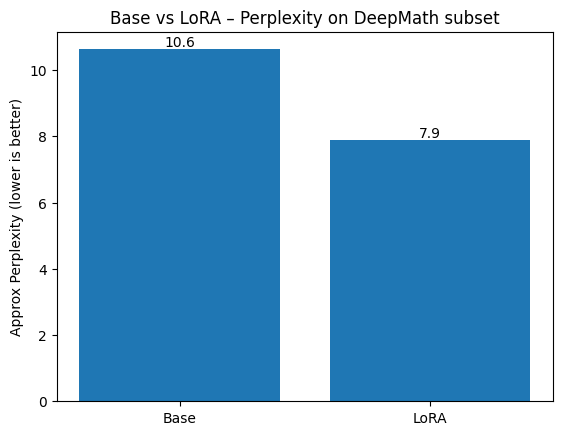

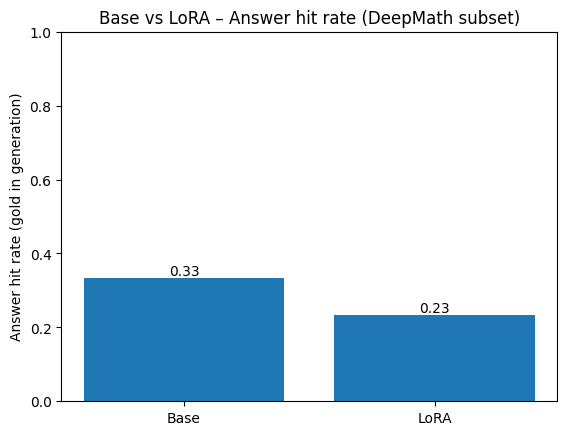

In [38]:
# Perplexity bar plot
plt.figure()
labels = ["Base", "LoRA"]
ppls = [base_ppl, lora_ppl]
plt.bar(labels, ppls)
plt.ylabel("Approx Perplexity (lower is better)")
plt.title("Base vs LoRA – Perplexity on DeepMath subset")
for i, v in enumerate(ppls):
    plt.text(i, v, f"{v:.1f}", ha="center", va="bottom")
plt.show()

# %%
# Answer hit rate bar plot
plt.figure()
hits = [base_hit, lora_hit]
plt.bar(labels, hits)
plt.ylabel("Answer hit rate (gold in generation)")
plt.title("Base vs LoRA – Answer hit rate (DeepMath subset)")
for i, v in enumerate(hits):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
plt.ylim(0, 1.0)
plt.show()

## Qualitative examples – base vs LoRA on DeepMath

In [39]:
def show_example(idx: int):
    ex = eval_prompts[idx]
    prompt = ex["prompt"]
    gold = ex["gold_answer"]

    print("=" * 80)
    print(f"Example {idx}")
    print("- Question / prompt:")
    print(prompt)
    print("\n- Gold answer:")
    print(gold)

    print("\n- Base model:")
    print(generate_answer(base_model, prompt))

    print("\n- LoRA model:")
    print(generate_answer(lora_model, prompt))

# Show a couple of examples
show_example(0)
show_example(1)

Example 0
- Question / prompt:
You are a helpful, concise assistant specializing in mathematics. Give clear, step-by-step answers when necessary.

Question: Evaluate the limit: \[ \lim_{x \to \infty} \sqrt{x} \left( \sqrt[3]{x+1} - \sqrt[3]{x-1} \right) \]
Answer:

- Gold answer:
0

- Base model:
Using the limit definition:

1. The limit is undefined for all values of x.

2. The limit is undefined for any value of x that is greater than or equal to the limit point.

3. The limit is undefined for any value of x that is less than the limit point.

4. The limit is undefined for any value of x that is not an integer.

5. The limit is undefined for any value of x for which the limit can be obtained by dividing both sides of the limit equation by x.

6. The limit is undefined for any value of x

- LoRA model:
\[ \lim_{x \to \infty} \sqrt{x} \left( \sqrt[3]{x+1} - \sqrt[3]{x-1} \right) = \lim_{x \to \infty} \sqrt[3]{x+1} \cdot \sqrt[3]{x-1} \]

This limit is a product of two limits: the limit

In [45]:
from bert_score import score
import transformers
import logging
import os

os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"  # you already have this

# Silence HF "Some weights were not initialized..." spam
transformers.logging.set_verbosity_error()
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

preds = [generate_answer(lora_model, eval_prompts[0]["prompt"])]
refs  = [eval_prompts[0]["gold_answer"]]

P, R, F1 = score(
    preds,
    refs,
    lang="en",
    model_type="roberta-large",
    rescale_with_baseline=True,
)
print(f"BERTScore – Precision: {P.mean().item():.4f}, Recall: {R.mean().item():.4f}, F1: {F1.mean().item():.4f}")


BERTScore – Precision: -0.5011, Recall: -0.0481, F1: -0.2835


In [48]:
from evaluate import load
rouge = load("rouge")
rouge.compute(predictions=preds, references=refs)["rougeL"]


np.float64(0.0)